In [1]:
import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,concatenate, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, ZeroPadding2D, LeakyReLU, ReLU, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time

# 1. Create Train/Val/Test Sets

In [2]:
X = np.load("../dataset/X_v2.npy")
objlist = np.load("../dataset/objlist_v2.npy")
dnnx = np.load("../dataset/dnnx_v2.npy")
y = np.load("../dataset/y_v2.npy",allow_pickle=True)

In [3]:
idx_drop = np.where(y=="QSO")[0]

In [4]:
X = np.delete(X,idx_drop,axis=0)
dnnx = np.delete(dnnx,idx_drop,axis=0)
y = np.delete(y,idx_drop,axis=0)
objlist = np.delete(objlist,idx_drop,axis=0)

In [5]:
y, label_strings = pd.factorize(y,sort=True)
y = to_categorical(y)
print(label_strings)

['GALAXY' 'STAR']


In [6]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.1,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.111111, random_state=42)

In [7]:
X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [8]:
dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

In [9]:
del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

In [10]:
print(dnnx_train.shape)
print(dnnx_val.shape)
print(dnnx_test.shape)

(79996, 24)
(10000, 24)
(10000, 24)


In [11]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

In [12]:
def plot_model_change(history,fname="output/time.pdf"):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'],label="Training Acc")
    plt.plot(history.history['val_accuracy'],label="Val Acc")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'],label="Training Loss")
    plt.plot(history.history['val_loss'],label="Val Loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(fname)
    plt.show()

# 2. Train a DNN Classifier

In [13]:
model = Sequential()

model.add(Dense(1024, activation="sigmoid", input_dim=dnnx_train.shape[1]))
model.add(Dropout(0.25))
model.add(Dense(256, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(128, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(64, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(32, activation="sigmoid"))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=0, patience=100, restore_best_weights=True)
cb = [es]
history = model.fit(dnnx_train, y_train,
                    batch_size=2048,
                    epochs = 4000,
                    validation_data = (dnnx_val,y_val),
                    callbacks = cb,
                    verbose = 2)

Epoch 1/4000
40/40 - 0s - loss: 0.7355 - accuracy: 0.5029 - val_loss: 0.6926 - val_accuracy: 0.4993
Epoch 2/4000
40/40 - 0s - loss: 0.7074 - accuracy: 0.5043 - val_loss: 0.6849 - val_accuracy: 0.7161
Epoch 3/4000
40/40 - 0s - loss: 0.6273 - accuracy: 0.6479 - val_loss: 0.5246 - val_accuracy: 0.7596
Epoch 4/4000
40/40 - 0s - loss: 0.4297 - accuracy: 0.8270 - val_loss: 0.3349 - val_accuracy: 0.8733
Epoch 5/4000
40/40 - 0s - loss: 0.3502 - accuracy: 0.8666 - val_loss: 0.2821 - val_accuracy: 0.8968
Epoch 6/4000
40/40 - 0s - loss: 0.3094 - accuracy: 0.8832 - val_loss: 0.2554 - val_accuracy: 0.9066
Epoch 7/4000
40/40 - 0s - loss: 0.2910 - accuracy: 0.8922 - val_loss: 0.2527 - val_accuracy: 0.9036
Epoch 8/4000
40/40 - 0s - loss: 0.2820 - accuracy: 0.8950 - val_loss: 0.2427 - val_accuracy: 0.9136
Epoch 9/4000
40/40 - 0s - loss: 0.2673 - accuracy: 0.9011 - val_loss: 0.2286 - val_accuracy: 0.9151
Epoch 10/4000
40/40 - 0s - loss: 0.2571 - accuracy: 0.9060 - val_loss: 0.2215 - val_accuracy: 0.9189

In [14]:
model.save("output/DNNClassifier.h5")

In [15]:
plot_model(model,"output/DNNMod.pdf",show_shapes=True)

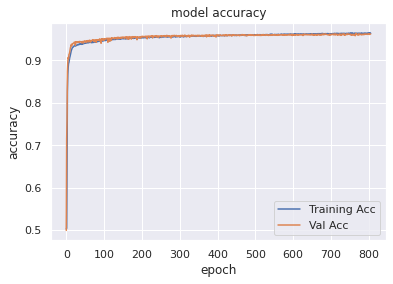

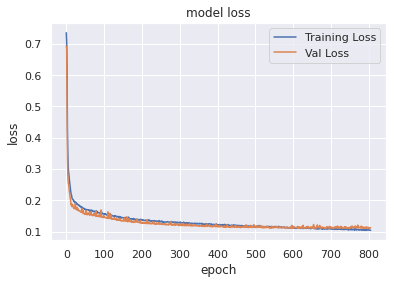

In [16]:
plot_model_change(history,fname="output/DNNTraining.pdf")

In [17]:
preds_test = model.predict(dnnx_test,batch_size=2048, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 9607 correct labels out of 10000 labels
Accuracy: 0.9607
Precision: 0.9607581307835749
Recall: 0.9607070234181138
F1 Score: 0.9606991318438225
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[4827  167]
 [ 226 4780]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      4994
           1       0.97      0.95      0.96      5006

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

(array([   0,    1,    2, ..., 9997, 9998, 9999]), 0.9607, 0.9607581307835749, 0.9607070234181138, array([[4827,  167],
       [ 226, 4780]]), '              precision    recall  f1-score   support\n\n           0       0.96      0.97      0.96      4994\n           1       0.97      0.95      0.96      5006\n\n    accuracy                           0.96     10000\n   macro avg       0.96      0.96      0.96     100

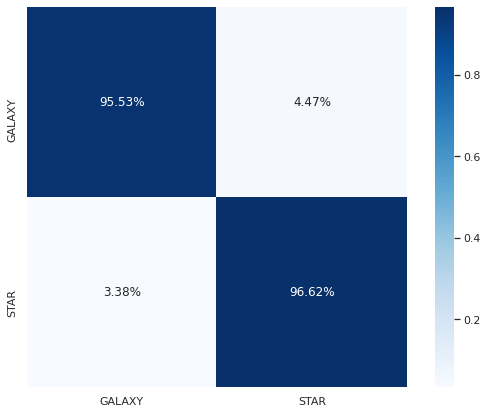

In [18]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/dnn_cm.pdf")

In [19]:
del(dnnx_train)

# 3. Train a CNN Classifier

In [20]:
inp_layer = tf.keras.Input(shape=X_train.shape[1:])

mod = Conv2D(filters=64, kernel_size=(5,5), padding='same')(inp_layer)
mod = ReLU()(mod)


# mod = AveragePooling2D(pool_size=(2, 2), strides=2)(mod)

c1 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c1 = ReLU()(c1)
c2 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c2 = ReLU()(c2)
c3 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c3 = ReLU()(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(c1)
c4 = ReLU()(c4)
c5 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(c1)
c5 = ReLU()(c5)
c6 = Conv2D(filters=64, kernel_size=(5,5), padding='same')(c2)
c6 = ReLU()(c6)
p1 = AveragePooling2D(pool_size=(1, 1))(c3)
mod = concatenate([c4,c5,c6,p1])

c7 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c7 = ReLU()(c7)
c8 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c8 = ReLU()(c8)
c9 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c9 = ReLU()(c9)
c10 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(c7)
c10 = ReLU()(c10)
c11 = Conv2D(filters=92, kernel_size=(3,3), padding='same')(c7)
c11 = ReLU()(c11)
c12 = Conv2D(filters=92, kernel_size=(5,5), padding='same')(c8)
c12 = ReLU()(c12)
p2 = AveragePooling2D(pool_size=(1, 1))(c9)
mod = concatenate([c10,c11,c12,p2])
mod = AveragePooling2D(pool_size=(2, 2))(mod)

c13 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c13 = ReLU()(c13)
c14 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c14 = ReLU()(c14)
c15 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c15 = ReLU()(c15)
c16 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(c13)
c16 = ReLU()(c16)
c17 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c13)
c17 = ReLU()(c17)
c18 = Conv2D(filters=128, kernel_size=(5,5), padding='same')(c14)
c18 = ReLU()(c18)
p3 = AveragePooling2D(pool_size=(1, 1))(c15)
mod = concatenate([c16,c17,c18,p3])

c19 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c19 = ReLU()(c19)
c20 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c20 = ReLU()(c20)
c21 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c21 = ReLU()(c21)
c22 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(c19)
c22 = ReLU()(c22)
c23 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c19)
c23 = ReLU()(c23)
c24 = Conv2D(filters=128, kernel_size=(5,5), padding='same')(c20)
c24 = ReLU()(c24)
p4 = AveragePooling2D(pool_size=(1, 1))(c21)
mod = concatenate([c22,c23,c24,p4])
mod = AveragePooling2D(pool_size=(2, 2))(mod)

c25 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c25 = ReLU()(c25)
c26 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c26 = ReLU()(c26)
c27 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(mod)
c27 = ReLU()(c27)
c28 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c25)
c28 = ReLU()(c28)
p5 = AveragePooling2D(pool_size=(1, 1))(c26)
mod = concatenate([c27,c28,p5])
mod = Flatten()(mod)    #Check
mod = Dense(1024)(mod)
mod = Dense(1024)(mod)
out_layer = Dense(2, activation="softmax") (mod)
model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])


In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)
datagen.fit(X_train)


es = EarlyStopping(monitor='val_loss', verbose=1, patience=30, restore_best_weights=True)

cb = [es]


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (79996, 32, 32, 5) (5 channels).
  ' channels).')


In [22]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=512),
                              epochs = 300, validation_data = (X_val,y_val),
                              callbacks = cb,
                              verbose = 1)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (79996, 32, 32, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/300
157/157 [==============================] - 75s 479ms/step - loss: 0.3457 - accuracy: 0.8432 - val_loss: 0.2100 - val_accuracy: 0.9195
Epoch 2/300
157/157 [==============================] - 74s 471ms/step - loss: 0.2115 - accuracy: 0.9203 - val_loss: 0.2007 - val_accuracy: 0.9250
Epoch 3/300
157/157 [==============================] - 74s 471ms/step - loss: 0.1986 - accuracy: 0.9253 - val_loss: 0.1846 - val_accuracy: 0.9306
Epoch 4/300
157/157 [==============================] - 75s 475ms/step - loss: 0.1904 - accuracy: 0.9287 - val_loss: 0.1882 - val_accuracy: 0.9264
Epoch 5/300
157/157 [==============================] - 75s 475ms/step - loss: 0.1814 - accuracy: 0.9320 - val_loss: 0.1762 - val_accuracy: 0.9301
Epoch 6/300
157/157 [==============================] - 74s 472ms/step - loss: 0.1729 - accuracy: 0.9361 - val_loss: 0.1795 - val_accuracy: 0.9318
Epoch 7/300
157/157 [==============================] - 75s 476ms/step - loss: 0.1696 - accuracy: 0.9366 - val_loss: 0.1632 -

In [23]:
model.save("output/CNNClassifier.h5")

In [24]:
plot_model(model,"output/CNNMod.pdf",show_shapes=True)

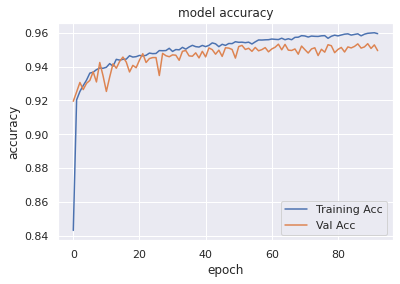

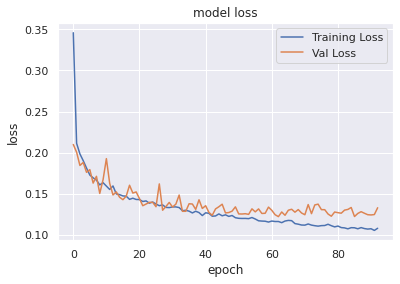

In [25]:
plot_model_change(history,fname="output/CNNTraining.pdf")

In [26]:
preds_test = model.predict(X_test,batch_size=1024, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 9522 correct labels out of 10000 labels
Accuracy: 0.9522
Precision: 0.9522327569805509
Recall: 0.9521951311609889
F1 Score: 0.9521987074530495
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[4735  259]
 [ 219 4787]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      4994
           1       0.95      0.96      0.95      5006

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

(array([   0,    1,    2, ..., 9997, 9998, 9999]), 0.9522, 0.9522327569805509, 0.9521951311609889, array([[4735,  259],
       [ 219, 4787]]), '              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.95      4994\n           1       0.95      0.96      0.95      5006\n\n    accuracy                           0.95     10000\n   macro avg       0.95      0.95      0.95     100

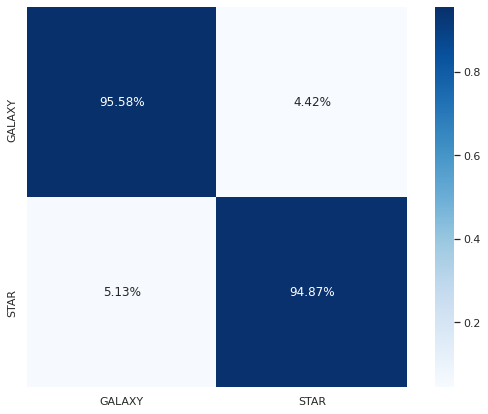

In [27]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/cnn_cm.pdf")

In [28]:
del(X_train)

# 4. Train the Ensemble Classifier

In [29]:
cnnclassifier = load_model("output/CNNClassifier.h5")
dnnclassifier = load_model("output/DNNClassifier.h5")

In [30]:
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(2, activation='softmax')(hidden)
    model = tf.keras.Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:
# define ensemble model
members = [cnnclassifier,dnnclassifier]
model = define_stacked_model(members)

In [32]:
filepath="output/EnsembleClassifier.h5"

checkpointcb = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,monitor='loss',mode='min',save_best_only=True,verbose=1,save_weights_only=False)
cb = [checkpointcb]


In [33]:
history = model.fit([X_val, dnnx_val],
                            y_val, epochs=100,
                            batch_size=512,
                            callbacks=cb,
                            verbose=1)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.7443
Epoch 00001: loss improved from inf to 0.55910, saving model to EnsembleClassifier.h5
20/20 [==============================] - 3s 129ms/step - loss: 0.5591 - accuracy: 0.7443
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.9536
Epoch 00002: loss improved from 0.55910 to 0.48908, saving model to EnsembleClassifier.h5
20/20 [==============================] - 2s 114ms/step - loss: 0.4891 - accuracy: 0.9536
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.9573
Epoch 00003: loss improved from 0.48908 to 0.43098, saving model to EnsembleClassifier.h5
20/20 [==============================] - 3s 129ms/step - loss: 0.4310 - accuracy: 0.9573
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.9607
Epoch 00004: loss improved from 0.43098 to 0.38116, saving model to EnsembleClassifier.

In [34]:
del(X_val, dnnx_val)

In [35]:
model = load_model("output/EnsembleClassifier.h5")

In [36]:
model.evaluate([X_test, dnnx_test],y_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.0890 - accuracy: 0.9693


[0.08898128569126129, 0.9692999720573425]

In [37]:
plot_model(model,"output/EnsembleMod.pdf",show_shapes=True)

In [38]:
preds_test = model.predict([X_test, dnnx_test],batch_size=512, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 9693 correct labels out of 10000 labels
Accuracy: 0.9693
Precision: 0.9693057585535809
Recall: 0.9692981557893443
F1 Score: 0.9692997761953686
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[4833  161]
 [ 146 4860]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4994
           1       0.97      0.97      0.97      5006

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

(array([   0,    1,    2, ..., 9997, 9998, 9999]), 0.9693, 0.9693057585535809, 0.9692981557893443, array([[4833,  161],
       [ 146, 4860]]), '              precision    recall  f1-score   support\n\n           0       0.97      0.97      0.97      4994\n           1       0.97      0.97      0.97      5006\n\n    accuracy                           0.97     10000\n   macro avg       0.97      0.97      0.97     100

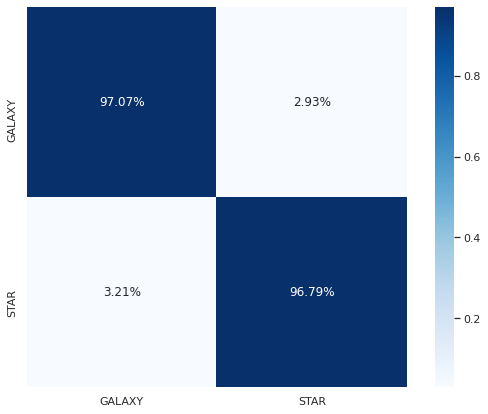

In [39]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/ensemble_cm.pdf")

# 5. Result Analysis

In [40]:
X = np.load("../dataset/X_v2.npy")
objlist = np.load("../dataset/objlist_v2.npy")
dnnx = np.load("../dataset/dnnx_v2.npy")
y = np.load("../dataset/y_v2.npy",allow_pickle=True)

idx_drop = np.where(y=="QSO")[0]


X = np.delete(X,idx_drop,axis=0)
dnnx = np.delete(dnnx,idx_drop,axis=0)
y = np.delete(y,idx_drop,axis=0)
objlist = np.delete(objlist,idx_drop,axis=0)

y, label_strings = pd.factorize(y,sort=True)
y = to_categorical(y)
print(label_strings)

zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.1,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1111111, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)


del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

['GALAXY' 'STAR']


In [41]:
model = load_model("output/EnsembleClassifier.h5")

In [42]:
preds_train = model.predict([X_train, dnnx_train],batch_size=512, verbose = 0)
print(get_metrics(preds_train.argmax(axis=1), y_train.argmax(axis=1),label_strings))

Identified 77836 correct labels out of 79996 labels
Accuracy: 0.9729986499324966
Precision: 0.9730328234586647
Recall: 0.9729929013252253
F1 Score: 0.9729978697460606
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[38703  1237]
 [  923 39133]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     39940
           1       0.97      0.98      0.97     40056

    accuracy                           0.97     79996
   macro avg       0.97      0.97      0.97     79996
weighted avg       0.97      0.97      0.97     79996

(array([    0,     1,     2, ..., 79993, 79994, 79995]), 0.9729986499324966, 0.9730328234586647, 0.9729929013252253, array([[38703,  1237],
       [  923, 39133]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.97      0.97     39940\n           1       0.97      0.98      0.97     40056\n\n    accuracy                           0.97     79996\n   macro avg

In [43]:
del(dnnx_train,X_train)

In [44]:
preds_val = model.predict([X_val, dnnx_val],batch_size=512, verbose = 0)
print(get_metrics(preds_val.argmax(axis=1), y_val.argmax(axis=1),label_strings))

Identified 9694 correct labels out of 10000 labels
Accuracy: 0.9694
Precision: 0.9694051385015374
Recall: 0.96938410548654
F1 Score: 0.9693940012242399
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[4917  149]
 [ 157 4777]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      5066
           1       0.97      0.97      0.97      4934

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

(array([   0,    1,    2, ..., 9997, 9998, 9999]), 0.9694, 0.9694051385015374, 0.96938410548654, array([[4917,  149],
       [ 157, 4777]]), '              precision    recall  f1-score   support\n\n           0       0.97      0.97      0.97      5066\n           1       0.97      0.97      0.97      4934\n\n    accuracy                           0.97     10000\n   macro avg       0.97      0.97      0.97     10000\n

In [45]:
del(X_val, dnnx_val)

In [46]:
preds_test = model.predict([X_test, dnnx_test],batch_size=512, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 9693 correct labels out of 10000 labels
Accuracy: 0.9693
Precision: 0.9693057585535809
Recall: 0.9692981557893443
F1 Score: 0.9692997761953686
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[4833  161]
 [ 146 4860]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4994
           1       0.97      0.97      0.97      5006

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

(array([   0,    1,    2, ..., 9997, 9998, 9999]), 0.9693, 0.9693057585535809, 0.9692981557893443, array([[4833,  161],
       [ 146, 4860]]), '              precision    recall  f1-score   support\n\n           0       0.97      0.97      0.97      4994\n           1       0.97      0.97      0.97      5006\n\n    accuracy                           0.97     10000\n   macro avg       0.97      0.97      0.97     100

In [47]:
df = pd.read_csv("../dataset/paperDF_v2.csv",index_col=0)
df = df[df["class"]!="QSO"].reset_index()
df = df.set_index(["objid"])

In [48]:
df.loc[objlist_train, ["set"]] = "TRAIN"
df.loc[objlist_val, ["set"]] = "VALIDATION"
df.loc[objlist_test, ["set"]] = "TEST"

In [49]:
df.loc[objlist_train, ["pred_class"]] = label_strings[preds_train.argmax(axis=1)]
df.loc[objlist_val, ["pred_class"]] = label_strings[preds_val.argmax(axis=1)]
df.loc[objlist_test, ["pred_class"]] = label_strings[preds_test.argmax(axis=1)]

In [50]:
pgal_train = preds_train[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_train = preds_train[:,np.where(label_strings=="STAR")[0][0]]

pgal_val = preds_val[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_val = preds_val[:,np.where(label_strings=="STAR")[0][0]]

pgal_test = preds_test[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_test = preds_test[:,np.where(label_strings=="STAR")[0][0]]

In [51]:
df.loc[objlist_train, ["prob_gal"]] = pgal_train
df.loc[objlist_train, ["prob_star"]] = pstar_train

df.loc[objlist_val, ["prob_gal"]] = pgal_val
df.loc[objlist_val, ["prob_star"]] = pstar_val

df.loc[objlist_test, ["prob_gal"]] = pgal_test
df.loc[objlist_test, ["prob_star"]] = pstar_test

In [52]:
df.to_csv("output/star_galaxy_results_v2.csv")

# 6. Some Plots

In [53]:
sns.set_palette("tab10")

In [54]:
df = pd.read_csv("output/star_galaxy_results_v2.csv")

In [55]:
subdflist = []

bin_size = 0.1
lower_bin_list = np.arange(20,23,bin_size)
bad_lower_bin=[]
acclist = []
f1list = []
reportlist = []
num_samplelist = []
starmaglist = []
galmaglist = []

for lower_bin in lower_bin_list:
#     print(f"******************** {lower_bin} < r <= {lower_bin+bin_size} ********************")
    subdf = df[(
        ((df["dered_r"]+df["extinction_r"]) > lower_bin) & 
        ((df["dered_r"]+df["extinction_r"]) <= lower_bin+bin_size)
    )]
    # Choose equal number of stars and galaxies
    min_num = subdf["class"].value_counts().min()
    if min_num < 50:
        bad_lower_bin.append(lower_bin)
        continue
    s1 = subdf[subdf["class"]=="GALAXY"].sample(n=min_num)
    galmaglist.append((s1["dered_r"]+s1["extinction_r"]).to_numpy())
    s2 = subdf[subdf["class"]=="STAR"].sample(n=min_num)
    starmaglist.append((s2["dered_r"]+s2["extinction_r"]).to_numpy())
    num_samplelist.append(min_num)
    subdf = pd.concat([s1,s2])
    subdflist.append(subdf)
    
    accuracy = metrics.accuracy_score(subdf["class"], subdf["pred_class"])
    f1score = metrics.f1_score(subdf["class"], subdf["pred_class"],average='macro')
    report = metrics.classification_report(subdf["class"], subdf["pred_class"],output_dict=True)
    reportlist.append(report)
    acclist.append(accuracy)
    f1list.append(f1score)

bad_lower_bin = np.array(bad_lower_bin)
lower_bin_list = lower_bin_list[~np.in1d(lower_bin_list,bad_lower_bin)]
# elems in lower_bin_list not in bad_lower_bin

galmaglist = np.concatenate(galmaglist)

starmaglist = np.concatenate(starmaglist)

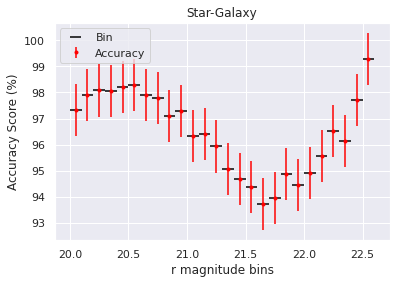

In [56]:
plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, xerr=bin_size/2, fmt=" ",color="black",label="Bin")
plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, yerr=0.01*100,fmt=".",color="red",label="Accuracy")
# plt.errorbar(lower_bin_list+bin_size/2, f1list, yerr=0.01,label="F1 Score")
plt.legend()
plt.title("Star-Galaxy")
plt.xlabel("r magnitude bins")
plt.ylabel("Accuracy Score (%)")
plt.savefig("output/V2_FAINT_SG.pdf")

In [57]:
subdfs = pd.concat(subdflist)
subdfs["r"]=subdfs["dered_r"]+subdfs["extinction_r"]

In [58]:
gal_recall_list = []
gal_precision_list = []
star_recall_list = []
star_precision_list = []
for r in reportlist:
    gal_recall_list.append(r["GALAXY"]["recall"])
    gal_precision_list.append(r["GALAXY"]["precision"])
    star_recall_list.append(r["STAR"]["recall"])
    star_precision_list.append(r["STAR"]["precision"])

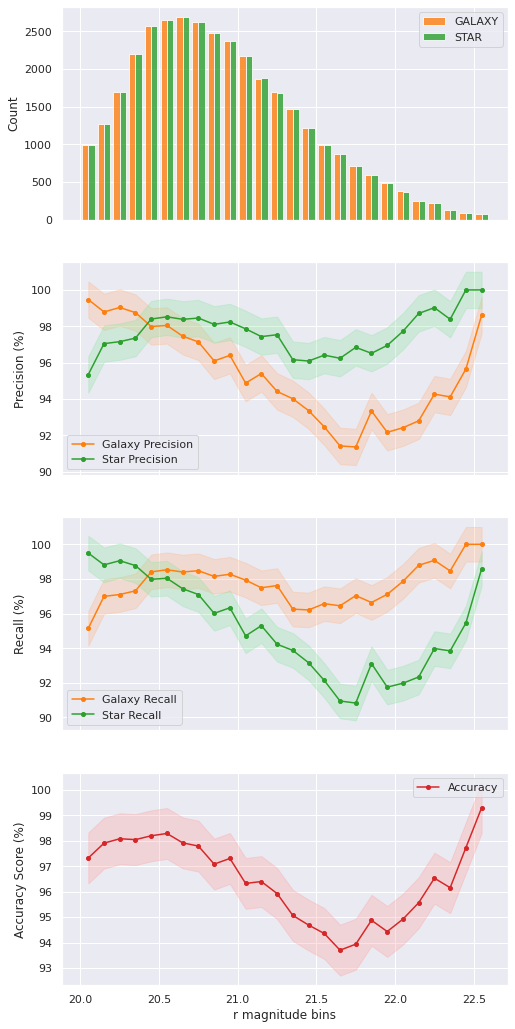

In [59]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,sharex=True, figsize=(8,18))

galcolor = sns.color_palette("tab10")[1]
starcolor = sns.color_palette("tab10")[2]
acccolor = sns.color_palette("tab10")[3]
f1color = sns.color_palette("tab10")[4]

dyfit = 0.01
x_ax = lower_bin_list+bin_size/2


d1 = subdfs[subdfs["class"]=="GALAXY"]["r"]
d2 = subdfs[subdfs["class"]=="STAR"]["r"]

ax1.hist([d1, d2], color=[galcolor,starcolor],
         alpha=0.8, label=["GALAXY","STAR"],bins=len(lower_bin_list))
ax1.set_ylabel("Count")

ax1.legend()


y_ax1 = np.array(gal_precision_list)
y_ax2 = np.array(star_precision_list)

ax2.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Precision",color=galcolor)
ax2.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax2.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Precision",color=starcolor)
ax2.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
                 color=sns.color_palette("pastel")[2], alpha=0.3)
ax2.set_ylabel("Precision (%)")
ax2.legend()



y_ax1 = np.array(gal_recall_list)
y_ax2 = np.array(star_recall_list)

ax3.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Recall",color=galcolor)
ax3.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax3.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Recall",color=starcolor)
ax3.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
             color=sns.color_palette("pastel")[2], alpha=0.3)
ax3.set_ylabel("Recall (%)")
ax3.legend()



y_ax1 = np.array(acclist)
y_ax2 = np.array(f1list)
ax4.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Accuracy",color=acccolor)
# ax4.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="F1 Score",color=f1color)
ax4.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[3], alpha=0.3)
ax4.set_ylabel("Accuracy Score (%)")
ax4.legend()

plt.xlabel("r magnitude bins")


# plt.suptitle("Star-Galaxy")
plt.savefig("output/Star_Galaxy_v2Set.pdf")
plt.show()

# 7. Compare with Kim-Brunner and Soumagnac

In [60]:
df = pd.read_csv("output/star_galaxy_results_v2.csv")
df = df[df["set"]=="TEST"]

In [61]:
from sklearn.metrics import precision_recall_curve
from scipy.interpolate import interp1d

def interpolate_xy(x_ax, y_ax, x_val):
    x_ax2 = x_ax.copy()
    y_ax2 = y_ax.copy()
    x_val2 = np.copy(x_val)
    
    xy_list = np.concatenate([x_ax2.reshape(-1,1),y_ax2.reshape(-1,1)],axis=1).tolist()
    x_ax2 = np.array(sorted(xy_list , key=lambda k: [k[0], k[1]]))[:,0]
    y_ax2 = np.array(sorted(xy_list , key=lambda k: [k[0], k[1]]))[:,1]
    
    f = interp1d(x=x_ax2, y=y_ax2, kind='linear')
    y_val = f(x_val2)
    
    return y_val


def calculate_pg(subdf, cg=0.96):
    '''
    For galaxy, the positive class = GALAXY
    '''

    pos_label = "GALAXY"
    probas_pred = subdf["prob_gal"].to_numpy()
    y_true = subdf["class"].to_numpy()
    
    pg_arr, cg_arr, thresholds = precision_recall_curve(
        y_true=y_true, probas_pred=probas_pred, pos_label=pos_label
    )
    
    # pg = pg_arr[np.argwhere(np.around(cg_arr,decimals=len_cg)==cg)].mean()
    
    # f = interp1d(x=cg_arr, y=pg_arr, kind='linear')
    # pg = f(cg)
    
    pg = interpolate_xy(x_ax = cg_arr, y_ax = pg_arr, x_val = cg)
    
    return pg

def calculate_cs(subdf, ps=0.97):
    '''
    For stars, the positive class = STAR
    '''
    
    pos_label = "STAR"
    probas_pred = subdf["prob_star"].to_numpy()
    y_true = subdf["class"].to_numpy()
    
    ps_arr, cs_arr, thresholds = precision_recall_curve(
        y_true=y_true, probas_pred=probas_pred, pos_label=pos_label
    )
    
    # cs = cs_arr[np.argwhere(np.around(ps_arr,decimals=len_ps)==ps)].mean()
    # f = interp1d(x=ps_arr, y=cs_arr, kind='linear')
    # cs = f(ps)
    
    cs = interpolate_xy(x_ax = ps_arr, y_ax = cs_arr, x_val = ps)
    
    return cs

## Kim Brunner

We want,
1. For GALAXY: $ p_g(c_g = 0.96) $ 
2. For STAR: $ c_s (p_s = 0.97) $

where p = precision (purity) and c = recall (completeness).

- For galaxy, c(recall/completeness) is x, pg is y
- For stars, p(precision/purity) is x, cs is y

In [62]:
bin_size = 0.05
lower_bin_list = np.arange(14,23,bin_size)
bad_lower_bin=[]
pglist = []
cslist = []
num_samplelist = []
starmaglist = []
galmaglist = []

for lower_bin in lower_bin_list:
    subdf = df[(
        ((df["dered_r"]+df["extinction_r"]) > lower_bin) & 
        ((df["dered_r"]+df["extinction_r"]) <= lower_bin+bin_size)
    )]
    
    min_num = subdf["class"].value_counts().min()
    # Choose equal number of stars and galaxies
    if min_num < 50 or subdf["class"].unique().shape[0] < 2:
        bad_lower_bin.append(lower_bin)
        continue
#     print(f"***** {(lower_bin):.2f} < r <= {(lower_bin+bin_size):.2f} *****")
    pg = calculate_pg(subdf, cg=0.96)
    try:
        cs = calculate_cs(subdf, ps=0.97)
    except ValueError as ve:
        print(f"{(lower_bin):.2f} < r <= {(lower_bin+bin_size):.2f}: {ve}")
        cs = np.nan
    
    pglist.append(pg)
    cslist.append(cs)
bad_lower_bin = np.array(bad_lower_bin)
lower_bin_list = lower_bin_list[~np.in1d(lower_bin_list,bad_lower_bin)]
# elems in lower_bin_list not in bad_lower_bin

pglist = np.array(pglist)
cslist = np.array(cslist)

19.95 < r <= 20.00: A value in x_new is below the interpolation range.
20.00 < r <= 20.05: A value in x_new is below the interpolation range.
20.05 < r <= 20.10: A value in x_new is below the interpolation range.
20.25 < r <= 20.30: A value in x_new is below the interpolation range.
20.45 < r <= 20.50: A value in x_new is below the interpolation range.


In [63]:
x_ax = lower_bin_list+bin_size/2

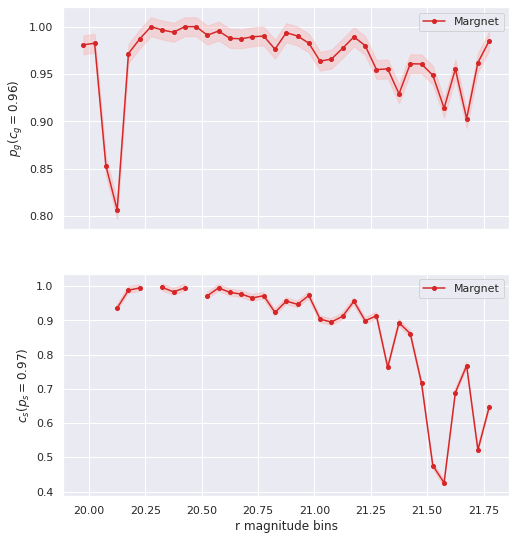

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True, figsize=(8,9))

galcolor = sns.color_palette("tab10")[1]
starcolor = sns.color_palette("tab10")[2]
acccolor = sns.color_palette("tab10")[3]
f1color = sns.color_palette("tab10")[4]

dyfit = 0.01
x_ax = lower_bin_list+bin_size/2
x_ax = x_ax

ax1.errorbar(x_ax, pglist,fmt="-o", ms=4, label="Margnet",color=acccolor)
ax1.fill_between(x_ax, pglist - dyfit, pglist + dyfit,
                 color=sns.color_palette("pastel")[3], alpha=0.3)
ax1.set_ylabel("$p_g(c_g = 0.96)$")
ax1.legend()

ax2.errorbar(x_ax, cslist,fmt="-o", ms=4, label="Margnet",color=acccolor)
ax2.fill_between(x_ax, cslist - dyfit, cslist + dyfit,
                 color=sns.color_palette("pastel")[3], alpha=0.3)
ax2.set_ylabel("$c_s(p_s = 0.97)$")
ax2.legend()


plt.xlabel("r magnitude bins")


# plt.suptitle("Star-Galaxy")
plt.savefig("output/EXP2Star_Galaxy_pg_cs.pdf")
plt.show()

## Soumagnac

We want,
1. For GALAXY: $ p_g(c_g = 0.96) $ 
2. For STAR: $ p_s (c_s = 0.25) $

where p = precision (purity) and c = recall (completeness).

In [65]:
def calculate_ps(subdf, cs=0.25):
    '''
    For star, the positive class = STAR
    '''    
    pos_label = "STAR"
    probas_pred = subdf["prob_star"].to_numpy()
    y_true = subdf["class"].to_numpy()
    
    ps_arr, cs_arr, thresholds = precision_recall_curve(
        y_true=y_true, probas_pred=probas_pred, pos_label=pos_label
    )
    
    # pg = pg_arr[np.argwhere(np.around(cg_arr,decimals=len_cg)==cg)].mean()
    
    # f = interp1d(x=cg_arr, y=pg_arr, kind='linear')
    # pg = f(cg)
    
    ps = interpolate_xy(x_ax = cs_arr, y_ax = ps_arr, x_val = cs)
    
    return ps

In [66]:
bin_size = 0.05
lower_bin_list = np.arange(14,23,bin_size)
bad_lower_bin=[]
pglist = []
pslist = []
num_samplelist = []
starmaglist = []
galmaglist = []

for lower_bin in lower_bin_list:
    subdf = df[(
        ((df["dered_i"]+df["extinction_i"]) > lower_bin) & 
        ((df["dered_i"]+df["extinction_i"]) <= lower_bin+bin_size)
    )]
    
    min_num = subdf["class"].value_counts().min()
    # Choose equal number of stars and galaxies
    if min_num < 50 or subdf["class"].unique().shape[0] < 2:
        bad_lower_bin.append(lower_bin)
        continue
#     print(f"***** {(lower_bin):.2f} < r <= {(lower_bin+bin_size):.2f} *****")
    pg = calculate_pg(subdf, cg=0.96)
    try:
        ps = calculate_ps(subdf, cs=0.25)
    except ValueError as ve:
        print(f"{(lower_bin):.2f} < r <= {(lower_bin+bin_size):.2f}: {ve}")
        ps = np.nan
    
    pglist.append(pg)
    pslist.append(ps)
bad_lower_bin = np.array(bad_lower_bin)
lower_bin_list = lower_bin_list[~np.in1d(lower_bin_list,bad_lower_bin)]
# elems in lower_bin_list not in bad_lower_bin

pglist = np.array(pglist)
pslist = np.array(pslist)

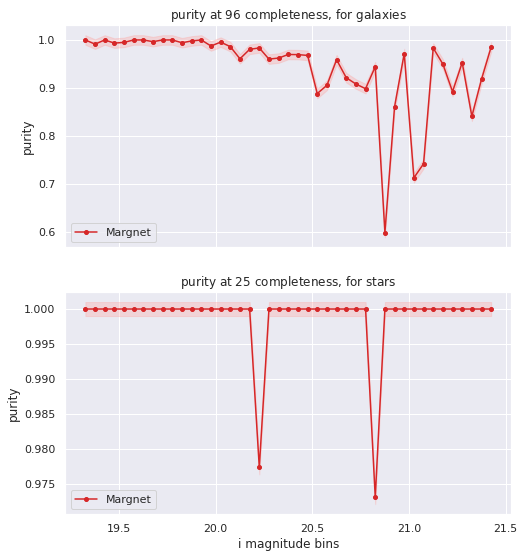

In [67]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, figsize=(8,9))

galcolor = sns.color_palette("tab10")[1]
starcolor = sns.color_palette("tab10")[2]
acccolor = sns.color_palette("tab10")[3]
f1color = sns.color_palette("tab10")[4]

dyfit = 0.01
x_ax = lower_bin_list+bin_size/2
x_ax = x_ax

ax1.errorbar(x_ax, pglist,fmt="-o", ms=4, label="Margnet",color=acccolor)
ax1.fill_between(x_ax, pglist - dyfit, pglist + dyfit,
                 color=sns.color_palette("pastel")[3], alpha=0.3)
ax1.set_ylabel("purity")
ax1.set_title("purity at $96%$ completeness, for galaxies")
ax1.legend()

ax2.errorbar(x_ax, pslist,fmt="-o", ms=4, label="Margnet",color=acccolor)
ax2.fill_between(x_ax, pslist - dyfit/10, pslist + dyfit/10,
                 color=sns.color_palette("pastel")[3], alpha=0.3)
ax2.set_ylabel("purity")
ax2.set_title("purity at $25%$ completeness, for stars")
ax2.legend()


plt.xlabel("i magnitude bins")


# plt.suptitle("Star-Galaxy")
plt.savefig("output/EXP2Star_Galaxy_pg_ps.pdf")
plt.show()